In [1]:
import pandas as pd

filepath = "data/ARM_stock_data.csv"
data = pd.read_csv(filepath)

print(data.head())

         Date       Open       High        Low      Close  Adj Close  \
0  2023-09-14  56.099998  66.279999  55.540001  63.590000  63.590000   
1  2023-09-15  68.629997  69.000000  60.750000  60.750000  60.750000   
2  2023-09-18  57.950001  58.741001  55.020000  58.000000  58.000000   
3  2023-09-19  56.250000  56.779999  53.880001  55.169998  55.169998   
4  2023-09-20  55.169998  55.400002  51.520000  52.910000  52.910000   

      Volume  
0  130534500  
1   74568900  
2   34571900  
3   18308600  
4   16369500  


In [2]:
print(data.isnull().sum())

data = data.dropna()

print(data.info())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       306 non-null    object 
 1   Open       306 non-null    float64
 2   High       306 non-null    float64
 3   Low        306 non-null    float64
 4   Close      306 non-null    float64
 5   Adj Close  306 non-null    float64
 6   Volume     306 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 16.9+ KB
None


In [3]:
data['Date'] = pd.to_datetime(data['Date'])

data = data.sort_values(by="Date")

data.to_csv("data/cleaned_ARM_stock_data.csv", index=False)
print("Cleaned data saved!")

Cleaned data saved!


In [4]:
prices = data['Close'].values
print(prices[:10])

[63.59000015 60.75       58.         55.16999817 52.90999985 52.15999985
 51.31999969 54.43999863 53.52000046 52.99000168]


In [5]:
import numpy as np

returns = np.diff(prices) / prices[:-1] # calculating percentage change
print(returns[:10])

[-0.04466111 -0.04526749 -0.04879314 -0.04096426 -0.01417501 -0.0161043
  0.06079499 -0.01689931 -0.00990282  0.04717871]


In [6]:
# Define thresholds for states
def categorize_return(r):
    if r > 0.01:    # Greater than 1% increase
        return "Increase"
    elif r < -0.01:  # Greater than 1% decrease
        return "Decrease"
    else:
        return "No Change"

states = [categorize_return(r) for r in returns]
print(states[:10])  # First 10 states


['Decrease', 'Decrease', 'Decrease', 'Decrease', 'Decrease', 'Decrease', 'Increase', 'Decrease', 'No Change', 'Increase']


In [7]:
from collections import Counter

# Initialize transition matrix
state_space = ["Increase", "Decrease", "No Change"]
transitions = {s: Counter() for s in state_space}

# Count transitions
for (current, next_state) in zip(states[:-1], states[1:]):
    transitions[current][next_state] += 1

# Display raw counts
print(transitions)

{'Increase': Counter({'Increase': 58, 'Decrease': 51, 'No Change': 22}), 'Decrease': Counter({'Increase': 48, 'Decrease': 44, 'No Change': 26}), 'No Change': Counter({'Increase': 25, 'Decrease': 22, 'No Change': 8})}


In [8]:
# Convert counts to probabilities
transition_matrix = {s: {t: count / sum(transitions[s].values()) 
                         for t, count in transitions[s].items()} 
                     for s in state_space}

# Display transition probabilities
print(transition_matrix)


{'Increase': {'Decrease': 0.3893129770992366, 'No Change': 0.16793893129770993, 'Increase': 0.44274809160305345}, 'Decrease': {'Decrease': 0.3728813559322034, 'Increase': 0.4067796610169492, 'No Change': 0.22033898305084745}, 'No Change': {'Increase': 0.45454545454545453, 'No Change': 0.14545454545454545, 'Decrease': 0.4}}


In [9]:
import json

# Save transition matrix
with open("data/transition_matrix.json", "w") as f:
    json.dump(transition_matrix, f)
print("Transition matrix saved!")


Transition matrix saved!


In [11]:
import json

# Load transition matrix
with open("data/transition_matrix.json", "r") as f:
    transition_matrix = json.load(f)

print(transition_matrix)  # Check the matrix structure


{'Increase': {'Decrease': 0.3893129770992366, 'No Change': 0.16793893129770993, 'Increase': 0.44274809160305345}, 'Decrease': {'Decrease': 0.3728813559322034, 'Increase': 0.4067796610169492, 'No Change': 0.22033898305084745}, 'No Change': {'Increase': 0.45454545454545453, 'No Change': 0.14545454545454545, 'Decrease': 0.4}}


In [12]:
import random

# Function to predict the next state
def predict_next_state(current_state, transition_matrix):
    probabilities = transition_matrix[current_state]
    states, probs = zip(*probabilities.items())
    return random.choices(states, probs)[0]

# Test the function
current_state = "Increase"  # Example
next_state = predict_next_state(current_state, transition_matrix)
print(f"From '{current_state}' to '{next_state}'")


From 'Increase' to 'Decrease'


In [13]:
# Predict a sequence of states
def predict_state_sequence(start_state, transition_matrix, steps=10):
    state_sequence = [start_state]
    for _ in range(steps):
        next_state = predict_next_state(state_sequence[-1], transition_matrix)
        state_sequence.append(next_state)
    return state_sequence

# Test the sequence prediction
predicted_sequence = predict_state_sequence("Increase", transition_matrix, steps=5)
print("Predicted Sequence:", predicted_sequence)


Predicted Sequence: ['Increase', 'No Change', 'Increase', 'Decrease', 'No Change', 'Increase']


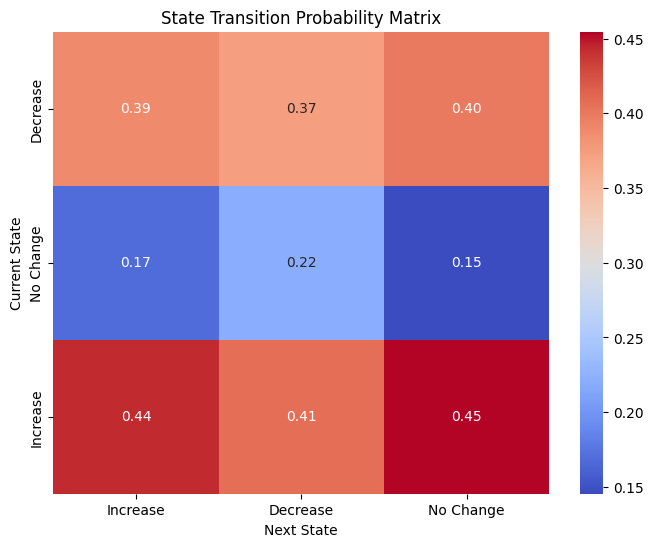

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert transition matrix to a DataFrame
df = pd.DataFrame(transition_matrix).fillna(0)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("State Transition Probability Matrix")
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.show()


In [16]:
state_to_change = {"Increase": 1, "Decrease": -1, "No Change": 0}
numerical_changes = [state_to_change[state] for state in predicted_sequence]


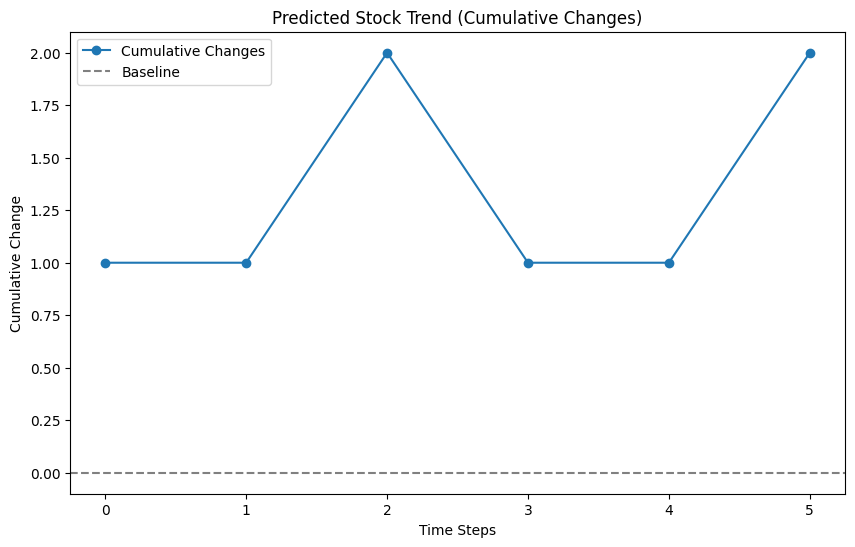

In [17]:
# Calculate cumulative changes
cumulative_changes = [sum(numerical_changes[:i+1]) for i in range(len(numerical_changes))]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(cumulative_changes, marker="o", label="Cumulative Changes")
plt.axhline(0, color="gray", linestyle="--", label="Baseline")
plt.title("Predicted Stock Trend (Cumulative Changes)")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Change")
plt.legend()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Gsgaa\\OneDrive\\Desktop\\Markov Trading Bot\\markov-trading-bot\\visualizations\\transition_matrix_heatmap.png'

<Figure size 640x480 with 0 Axes>